In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from nltk.sentiment import SentimentIntensityAnalyzer

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer


In [7]:
# Preprocessed data
df = pd.read_csv("preprocessed_imdb.csv")

# Topic model & TF-IDF
nmf_model = joblib.load("nmf_topic_model.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
tfidf_matrix = joblib.load("tfidf_matrix.pkl")


In [8]:
W = nmf_model.transform(tfidf_matrix)

df['topic'] = W.argmax(axis=1)

df[['clean_text', 'topic']].head()


,clean_text,topic
0,reviewer mentioned oz episode youll hooked rig...,2
1,wonderful little production filming technique ...,6
2,thought wonderful way spend time hot summer we...,8
3,basically there family little boy jake think t...,9
4,petter matteis love time money visually stunni...,6


In [9]:
topic_names = {
    0: "Opinions",
    1: "Bad Acting",
    2: "TV Shows",
    3: "Performance",
    4: "Worst Movies",
    5: "Story & Plot",
    6: "Film Work",
    7: "Memories",
    8: "Comedy",
    9: "Family",
    10: "Horror",
    11: "Adaptations"
}

df['topic_name'] = df['topic'].map(topic_names)


In [10]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['clean_text'].apply(get_sentiment)


In [11]:
topic_sentiment = pd.crosstab(
    df['topic_name'],
    df['sentiment'],
    normalize='index'
)

topic_sentiment


sentiment,Negative,Neutral,Positive
topic_name,,,
Adaptations,0.245833,0.010714,0.743452
Bad Acting,0.663070,0.016408,0.320521
Comedy,0.167893,0.008412,0.823694
Family,0.206266,0.008921,0.784813
Film Work,0.308522,0.012058,0.679420
Horror,0.596042,0.016298,0.387660
Memories,0.226355,0.008767,0.764878
Opinions,0.491735,0.014765,0.493500
Performance,0.066890,0.004194,0.928916


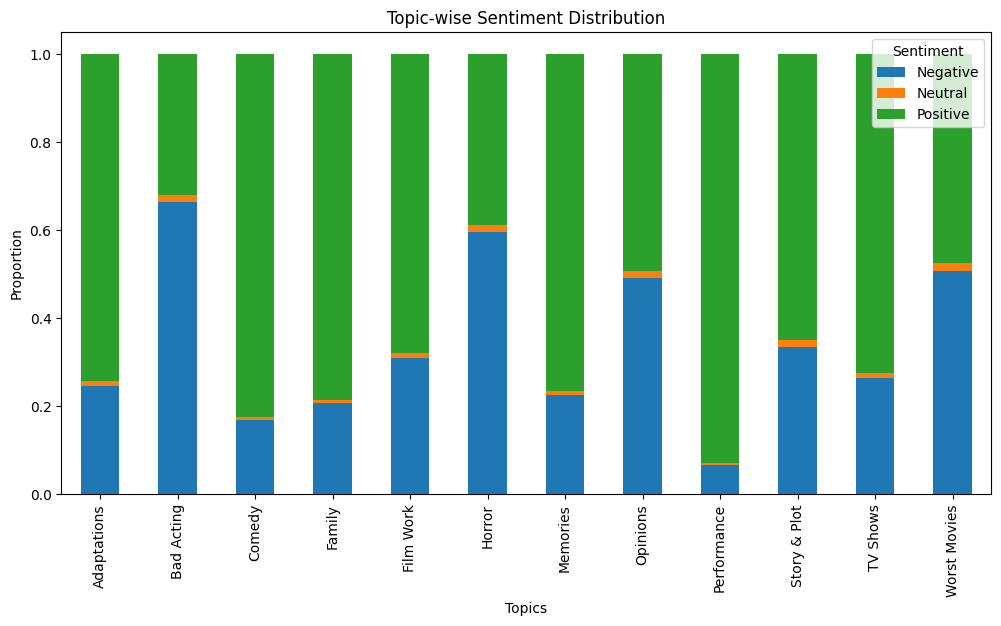

In [12]:
topic_sentiment.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)

plt.title("Topic-wise Sentiment Distribution")
plt.ylabel("Proportion")
plt.xlabel("Topics")
plt.legend(title="Sentiment")
plt.show()


In [13]:
def topic_summary(topic_name, n=5):
    texts = df[df['topic_name'] == topic_name]['clean_text']
    
    combined_text = " ".join(texts[:200])  # limit for stability
    
    try:
        return summarize(combined_text, word_count=80)
    except:
        return combined_text[:500]


In [14]:
topic_summaries = {}

for topic in df['topic_name'].unique():
    topic_summaries[topic] = topic_summary(topic)

topic_summaries


{'TV Shows': 'reviewer mentioned oz episode youll hooked right exactly happened first struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death sta',
 'Film Work': 'wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely chosen michael sheen polari voice pat truly seamless editing guided reference williams diary entry worth terrificly written performed piece masterful production great master comedy life realism come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge

In [15]:
final_output = df[['clean_text', 'topic_name', 'sentiment']]

final_output.head()


,clean_text,topic_name,sentiment
0,reviewer mentioned oz episode youll hooked rig...,TV Shows,Negative
1,wonderful little production filming technique ...,Film Work,Positive
2,thought wonderful way spend time hot summer we...,Comedy,Positive
3,basically there family little boy jake think t...,Family,Negative
4,petter matteis love time money visually stunni...,Film Work,Positive


In [16]:
final_output.to_csv("final_integrated_output.csv", index=False)


In [17]:
import json

with open("topic_summaries.json", "w") as f:
    json.dump(topic_summaries, f, indent=4)
